# Packages & Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate

In [ ]:
# Path to your saved split folder
split_dir = '/content/drive/MyDrive/new classification/Splits3/'


# Load image data
X_image_train = np.load(os.path.join(split_dir, 'X_image_train.npy'))
X_image_val   = np.load(os.path.join(split_dir, 'X_image_val.npy'))
X_image_test  = np.load(os.path.join(split_dir, 'X_image_test.npy'))

# Load mask data
X_mask_train = np.load(os.path.join(split_dir, 'X_mask_train.npy'))
X_mask_val   = np.load(os.path.join(split_dir, 'X_mask_val.npy'))
X_mask_test  = np.load(os.path.join(split_dir, 'X_mask_test.npy'))

# Load semantic data
X_semantic_train = np.load(os.path.join(split_dir, 'X_semantic_train.npy'))
X_semantic_val   = np.load(os.path.join(split_dir, 'X_semantic_val.npy'))
X_semantic_test = np.load(os.path.join(split_dir, 'X_semantic_test.npy'))

# Load labels
y_train = np.load(os.path.join(split_dir, 'y_train.npy'))
y_val   = np.load(os.path.join(split_dir, 'y_val.npy'))
y_test  = np.load(os.path.join(split_dir, 'y_test.npy'))


Using the output of the segmentation model

In [ ]:
X_image_test2  = np.load('/content/drive/MyDrive/Segmentation/testing segmentation clas perf/X_image_test.npy')
X_mask_test2  = np.load('/content/drive/MyDrive/Segmentation/testing segmentation clas perf/X_mask_test.npy')
X_semantic_test2 = np.load('/content/drive/MyDrive/Segmentation/testing segmentation clas perf/X_semantic_test.npy')
y_test2  = np.load('/content/drive/MyDrive/Segmentation/testing segmentation clas perf/y_test.npy')

Normalize and standardise

In [ ]:
def normalize_minmax(img, clip_min=-1.0, clip_max=3.0):
    img = np.clip(img, clip_min, clip_max)
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min + 1e-8)

X_image_train = np.array([normalize_minmax(img) for img in X_image_train])
X_image_val   = np.array([normalize_minmax(img) for img in X_image_val])
X_image_test  = np.array([normalize_minmax(img) for img in X_image_test])
X_image_test2  = np.array([normalize_minmax(img) for img in X_image_test2])

print("Train shape:", X_image_train.shape)
print("Train dtype:", X_image_train.dtype)
print("Train min/max:", X_image_train.min(), X_image_train.max())

scaler = StandardScaler()
X_semantic_train = scaler.fit_transform(X_semantic_train)
X_semantic_val   = scaler.transform(X_semantic_val)
X_semantic_test  = scaler.transform(X_semantic_test)
X_semantic_test2  = scaler.transform(X_semantic_test2)


# CNN Only

In [ ]:
def ImageCNN_Model(input_shape=(64, 64, 1), dropout_rate=0.5):
    inputs = Input(shape=input_shape)

    # Conv block 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Conv block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Conv block 3
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Dense layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the model
ImageCNN = ImageCNN_Model()

# Compile
ImageCNN.compile(optimizer=Adam(learning_rate=1e-4),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])


In [ ]:
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=8,                  # Stops if no improvement for 5 epochs
    restore_best_weights=True
)

historyImageCNN32 = ImageCNN.fit(
    x = X_image_train,
    y = y_train,
    validation_data = (X_image_val, y_val),
    epochs = 25,
    batch_size = 16,
    callbacks = [earlystop_cb],
    verbose = 1,
    shuffle = True
)


# Tripple Branch

In [ ]:
def build_three_branch_model(dropout_rate=0.5):
    # --- Image branch ---
    image_input = Input(shape=(64, 64, 1), name="image_input")
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Flatten()(x1)
    x1 = Dense(256, activation='relu')(x1)
    x1 = Dropout(dropout_rate)(x1)

    # --- Mask branch ---
    mask_input = Input(shape=(64, 64, 1), name="mask_input")
    x2 = Conv2D(16, (3, 3), activation='relu', padding='same')(mask_input)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Flatten()(x2)
    x2 = Dense(64, activation='relu')(x2)
    x2 = Dropout(dropout_rate)(x2)

    # --- Semantic branch ---
    semantic_input = Input(shape=(4,), name="semantic_input")
    x3 = Dense(32, activation='relu')(semantic_input)
    x3 = Dropout(dropout_rate)(x3)
    x3 = Dense(16, activation='relu')(x3)
    x3 = Dropout(dropout_rate)(x3)

    # --- Concatenate and output ---
    combined = Concatenate()([x1, x2, x3])
    x = Dense(64, activation='relu')(combined)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[image_input, mask_input, semantic_input], outputs=output)
    return model

three_branch_model = build_three_branch_model()
three_branch_model.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

In [ ]:
# Training setup
historyThreeBranch = three_branch_model.fit(
    x ={ "image_input": X_image_train, "mask_input": X_mask_train, "semantic_input": X_semantic_train},
    y =y_train,
    validation_data =({"image_input": X_image_val, "mask_input": X_mask_val, "semantic_input": X_semantic_val}, y_val),
    epochs =25,
    batch_size =64,
    callbacks =[EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)],
    verbose =1,
    shuffle=True)

# Load PreTrained Model Weights

In [ ]:
ImageCNN.load_weights('/content/drive/MyDrive/new classification/Model Weights/ImageCNN.weights.h5')
three_branch_model.load_weights('/content/drive/MyDrive/new classification/Model Weights/ThreeBranch.weights.h5')

# Plots & Evaluation

In [ ]:
# List of histories and model labels
histories = [historyImageCNN32_dict, historyThreeBranch_dict]
model_labels = ['CNN', 'Multi-Branch']

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, (history, label) in enumerate(zip(histories, model_labels)):
    # Loss subplot
    axs[0, i].plot(history['loss'], label='Train Loss')
    axs[0, i].plot(history['val_loss'], label='Val Loss')
    axs[0, i].set_title(f'Loss - {label}')
    axs[0, i].set_xlabel('Epoch')
    axs[0, i].set_ylabel('Loss')
    axs[0, i].legend()

    # Accuracy subplot
    axs[1, i].plot(history['accuracy'], label='Train Acc')
    axs[1, i].plot(history['val_accuracy'], label='Val Acc')
    axs[1, i].set_title(f'Accuracy - {label}')
    axs[1, i].set_xlabel('Epoch')
    axs[1, i].set_ylabel('Accuracy')
    axs[1, i].legend()

plt.tight_layout()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


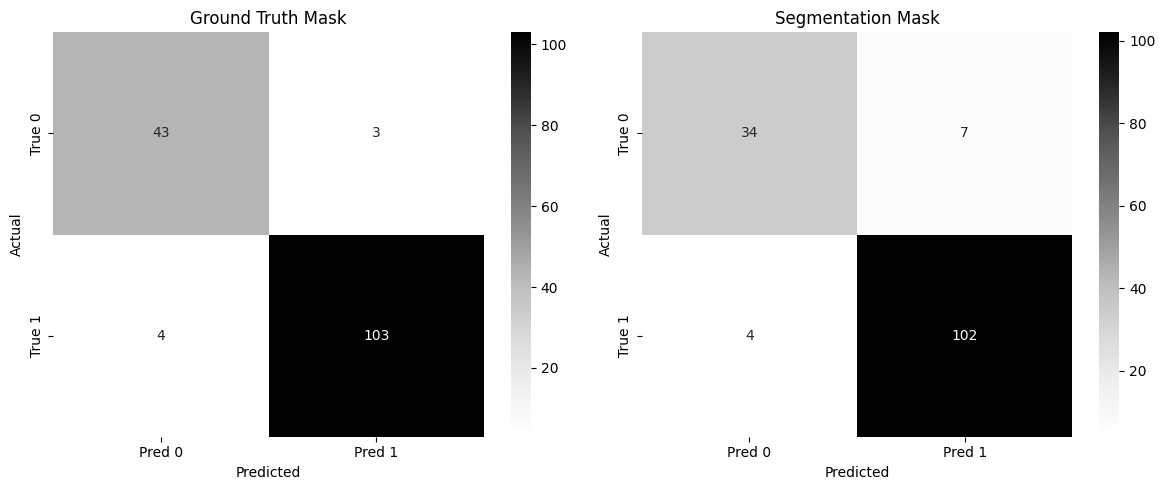

Ground Truth Mask - Classification Report
              precision    recall  f1-score   support

           0     0.9149    0.9348    0.9247        46
           1     0.9717    0.9626    0.9671       107

    accuracy                         0.9542       153
   macro avg     0.9433    0.9487    0.9459       153
weighted avg     0.9546    0.9542    0.9544       153

------------------------------------------------------------
Segmentation Mask - Classification Report
              precision    recall  f1-score   support

           0     0.8947    0.8293    0.8608        41
           1     0.9358    0.9623    0.9488       106

    accuracy                         0.9252       147
   macro avg     0.9153    0.8958    0.9048       147
weighted avg     0.9243    0.9252    0.9243       147

------------------------------------------------------------


In [ ]:
def plot_side_by_side_confusions(gt_true, seg_true, gt_probs, seg_probs):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Ground Truth Confusion Matrix
    gt_pred = (gt_probs > 0.45).astype(int)
    cm_gt = confusion_matrix(gt_true, gt_pred)
    sns.heatmap(cm_gt, annot=True, fmt="d", cmap="Greys", ax=axs[0],
                xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
    axs[0].set_title("Ground Truth Mask")
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("Actual")

    # Segmentation Output Confusion Matrix
    seg_pred = (seg_probs > 0.45).astype(int)
    cm_seg = confusion_matrix(seg_true, seg_pred)
    sns.heatmap(cm_seg, annot=True, fmt="d", cmap="Greys", ax=axs[1],
                xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
    axs[1].set_title("Segmentation Mask")
    axs[1].set_xlabel("Predicted")
    axs[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

    # Print classification reports
    print("Ground Truth Mask - Classification Report")
    print(classification_report(gt_true, gt_pred, digits=4))
    print("-" * 60)
    print("Segmentation Mask - Classification Report")
    print(classification_report(seg_true, seg_pred, digits=4))
    print("-" * 60)

# --- Predict ---
y_pred_gt = three_branch_model.predict({
    "image_input": X_image_test2,
    "mask_input": X_mask_test2,
    "semantic_input": X_semantic_test2
}).ravel()

y_pred_seg = three_branch_model.predict({
    "image_input": X_image_test,
    "mask_input": X_mask_test,
    "semantic_input": X_semantic_test
}).ravel()

# --- Plot ---
plot_side_by_side_confusions(y_test2, y_test, y_pred_gt, y_pred_seg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
AUROC: 0.956


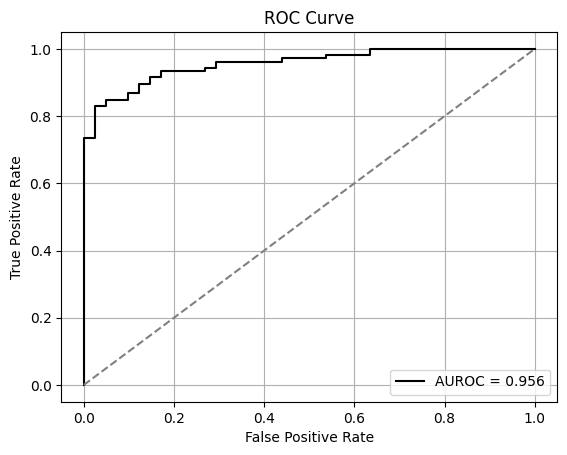

In [ ]:
# Get predicted probabilities for the test set
y_scores = ImageCNN.predict(X_image_test).ravel()  # Flatten to shape (n_samples,)
y_true = y_test  # Your true test labels (should be 0 or 1)

# Compute AUROC
auroc = roc_auc_score(y_true, y_scores)
print(f"AUROC: {auroc:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.3f}', color='black')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
AUROC: 0.956


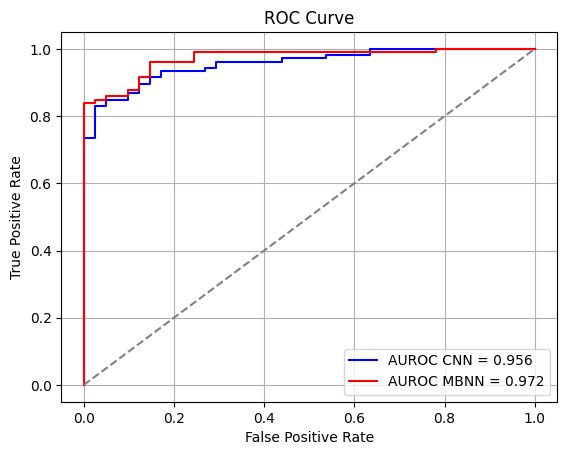

In [ ]:
# Predict probabilities
y_scores2 = three_branch_model.predict({
    "image_input": X_image_test,
    "mask_input": X_mask_test,
    "semantic_input": X_semantic_test
}).ravel()

# Ground truth
y_true = y_test

# Compute AUROC
auroc2 = roc_auc_score(y_true, y_scores2)
print(f"AUROC: {auroc:.3f}")

# Plot ROC curve
fpr2, tpr2, _ = roc_curve(y_true, y_scores2)
plt.plot(fpr, tpr, label=f'AUROC Ground Truth Mask= {auroc:.3f}', color='blue')
plt.plot(fpr2, tpr2, label=f'AUROC Segmentation Mask= {auroc2:.3f}', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MBNN')
plt.legend()
plt.grid(True)
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


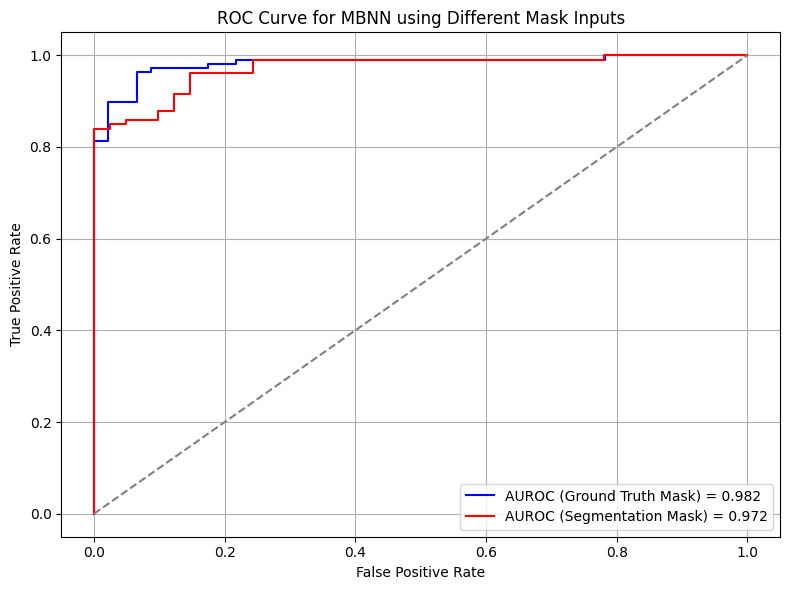

In [ ]:
# Predict with ground truth masks
y_scores_gt = three_branch_model.predict({
    "image_input": X_image_test2,
    "mask_input": X_mask_test2,  # Ground truth binary masks
    "semantic_input": X_semantic_test2
}).ravel()

# Predict with segmentation model output masks
y_scores_seg = three_branch_model.predict({
    "image_input": X_image_test,
    "mask_input": X_mask_test,  # Segmentation model output
    "semantic_input": X_semantic_test
}).ravel()

# Ground truth labels
y_true2 = y_test2
y_true = y_test

# Compute AUROC
auroc_gt = roc_auc_score(y_true2, y_scores_gt)
auroc_seg = roc_auc_score(y_true, y_scores_seg)

# Compute ROC curves
fpr_gt, tpr_gt, _ = roc_curve(y_true2, y_scores_gt)
fpr_seg, tpr_seg, _ = roc_curve(y_true, y_scores_seg)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_gt, tpr_gt, label=f'AUROC (Ground Truth Mask) = {auroc_gt:.3f}', color='blue')
plt.plot(fpr_seg, tpr_seg, label=f'AUROC (Segmentation Mask) = {auroc_seg:.3f}', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MBNN using Different Mask Inputs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Error Analysis

In [ ]:
# Flatten and binarize
y_pred_CNN = (y_pred_cnn > 0.45).astype(int).flatten()
y_pred_Three = (y_pred_three > 0.45).astype(int).flatten()
y_true_flat = y_test.flatten()

# CNN correct, Three wrong
CNN_correct_Three_wrong = np.where((y_pred_CNN == y_true_flat) & (y_pred_Three != y_true_flat))[0]

# Three correct, CNN wrong
Three_correct_CNN_wrong = np.where((y_pred_Three == y_true_flat) & (y_pred_CNN != y_true_flat))[0]

# Both wrong
Both_wrong = np.where((y_pred_CNN != y_true_flat) & (y_pred_Three != y_true_flat))[0]

# Both right
Both_right = np.where((y_pred_CNN == y_true_flat) & (y_pred_Three == y_true_flat))[0]

# Print counts
print(f"CNN correct, Three wrong: {len(CNN_correct_Three_wrong)} examples")
print(f"Three correct, CNN wrong: {len(Three_correct_CNN_wrong)} examples")
print(f"Both models wrong: {len(Both_wrong)} examples")
print(f"Both models correct: {len(Both_right)} examples")

# Print first 8 indices from each
print("First 8 - CNN correct, Three wrong:", CNN_correct_Three_wrong[:8])
print("First 8 - Three correct, CNN wrong:", Three_correct_CNN_wrong[:8])
print("First 8 - Both models wrong:", Both_wrong[:8])



CNN correct, Three wrong: 5 examples
Three correct, CNN wrong: 10 examples
Both models wrong: 6 examples
Both models correct: 126 examples
First 8 - CNN correct, Three wrong: [ 43  49  56 119 135]
First 8 - Three correct, CNN wrong: [ 27  32  44  54  62  96  99 115]
First 8 - Both models wrong: [ 26  82  98 100 134 141]


In [ ]:
# Feature names
feature_names = ["spiculation_proxy", "compactness", "solidity", "diameter"]

# Group index dictionary using your variables
group_indices = {
    "CNN_correct_Three_wrong": CNN_correct_Three_wrong,
    "Three_correct_CNN_wrong": Three_correct_CNN_wrong,
    "Both_wrong": Both_wrong,
    "Both_right": Both_right
}

# Loop through groups and compute stats
for group_name, indices in group_indices.items():
    group_data = X_semantic_test[indices]
    df = pd.DataFrame(group_data, columns=feature_names)

    print(f"\n🔍 Semantic feature stats for: {group_name} (n = {len(df)})\n")

    print("→ Mean:\n", df.mean().round(4), "\n")
    print("→ Std Dev:\n", df.std().round(4), "\n")
    print("→ Min:\n", df.min().round(4), "\n")
    print("→ Max:\n", df.max().round(4), "\n")
    print("→ Median:\n", df.median().round(4), "\n")
    print("→ Correlation matrix:\n", df.corr().round(4), "\n")
    print("-" * 60)


🔍 Semantic feature stats for: CNN_correct_Three_wrong (n = 1)

→ Mean:
 spiculation_proxy   -0.3556
compactness         -0.0713
solidity            -0.0955
diameter             0.1149
dtype: float32 

→ Std Dev:
 spiculation_proxy   NaN
compactness         NaN
solidity            NaN
diameter            NaN
dtype: float32 

→ Min:
 spiculation_proxy   -0.3556
compactness         -0.0713
solidity            -0.0955
diameter             0.1149
dtype: float32 

→ Max:
 spiculation_proxy   -0.3556
compactness         -0.0713
solidity            -0.0955
diameter             0.1149
dtype: float32 

→ Median:
 spiculation_proxy   -0.3556
compactness         -0.0713
solidity            -0.0955
diameter             0.1149
dtype: float32 

→ Correlation matrix:
                    spiculation_proxy  compactness  solidity  diameter
spiculation_proxy                NaN          NaN       NaN       NaN
compactness                      NaN          NaN       NaN       NaN
solidity                  

In [ ]:
# Feature names
feature_names = ["spiculation_proxy", "compactness", "solidity", "diameter"]

# Group index dictionary
group_indices = {
    "CNN correct, Three wrong": CNN_correct_Three_wrong,
    "Three correct, CNN wrong": Three_correct_CNN_wrong,
    "Both models wrong": Both_wrong,
    "Both models correct": Both_right
}

# For each group
for group_title, indices in group_indices.items():
    group_data = X_semantic_test[indices]
    df = pd.DataFrame(group_data, columns=feature_names)

    print(f"\n📊 Semantic Feature Statistics — {group_title} (n = {len(df)})")

    if len(df) >= 1:
        # Stats table
        stats_df = pd.DataFrame({
            "mean": df.mean(),
            "std": df.std(),
            "min": df.min(),
            "max": df.max(),
            "median": df.median()
        }).round(4)

        display(stats_df)  # If in Jupyter/Colab
        # Or: print(stats_df.to_string())

        # Correlation matrix
        if len(df) > 1:
            print(f"\n🔗 Correlation Matrix — {group_title}")
            corr_df = df.corr().round(4)
            display(corr_df)
            # Or: print(corr_df.to_string())
        else:
            print(f"\n⚠️ Correlation Matrix — {group_title}: Only one sample, correlation undefined.")

    else:
        print("⚠️ No data in this group. Skipping.")



📊 Semantic Feature Statistics — CNN correct, Three wrong (n = 1)


,mean,std,min,max,median
spiculation_proxy,-0.3556,NaN,-0.3556,-0.3556,-0.3556
compactness,-0.0713,NaN,-0.0713,-0.0713,-0.0713
solidity,-0.0955,NaN,-0.0955,-0.0955,-0.0955
diameter,0.1149,NaN,0.1149,0.1149,0.1149



⚠️ Correlation Matrix — CNN correct, Three wrong: Only one sample, correlation undefined.

📊 Semantic Feature Statistics — Three correct, CNN wrong (n = 10)


,mean,std,min,max,median
spiculation_proxy,-0.3043,0.1203,-0.4551,-0.0830,-0.3266
compactness,-0.0576,0.5636,-0.9672,0.5962,-0.0476
solidity,0.0117,1.0576,-1.0009,1.6359,-0.4717
diameter,-0.0127,1.0313,-1.3224,1.8114,-0.1395



🔗 Correlation Matrix — Three correct, CNN wrong


,spiculation_proxy,compactness,solidity,diameter
spiculation_proxy,1.0000,0.9189,-0.8181,-0.9399
compactness,0.9189,1.0000,-0.7311,-0.9479
solidity,-0.8181,-0.7311,1.0000,0.8850
diameter,-0.9399,-0.9479,0.8850,1.0000



📊 Semantic Feature Statistics — Both models wrong (n = 6)


,mean,std,min,max,median
spiculation_proxy,-0.2980,0.1048,-0.3530,-0.0852,-0.3365
compactness,-0.2330,0.1882,-0.4750,0.0445,-0.1996
solidity,-0.2761,0.5527,-0.9318,0.7016,-0.4077
diameter,-0.2469,0.5336,-1.3167,0.0883,-0.0737



🔗 Correlation Matrix — Both models wrong


,spiculation_proxy,compactness,solidity,diameter
spiculation_proxy,1.0000,0.1101,-0.6367,-0.9961
compactness,0.1101,1.0000,0.6510,-0.0517
solidity,-0.6367,0.6510,1.0000,0.6819
diameter,-0.9961,-0.0517,0.6819,1.0000



📊 Semantic Feature Statistics — Both models correct (n = 136)


,mean,std,min,max,median
spiculation_proxy,-0.3533,0.0734,-0.5315,-0.1643,-0.3717
compactness,-0.2264,0.6264,-3.3194,0.5962,-0.1051
solidity,0.4821,1.0324,-0.9712,2.8854,0.3154
diameter,0.3193,0.9264,-1.0728,5.6507,0.2980



🔗 Correlation Matrix — Both models correct


,spiculation_proxy,compactness,solidity,diameter
spiculation_proxy,1.0000,0.6788,-0.7780,-0.9066
compactness,0.6788,1.0000,-0.2834,-0.7933
solidity,-0.7780,-0.2834,1.0000,0.6955
diameter,-0.9066,-0.7933,0.6955,1.0000


In [ ]:
# Semantic feature names
feature_names = ["spiculation_proxy", "compactness", "solidity", "diameter"]

# Group index dictionary
group_indices = {
    "CNN_correct_Three_wrong": CNN_correct_Three_wrong,
    "Three_correct_CNN_wrong": Three_correct_CNN_wrong,
    "Both_wrong": Both_wrong,
    "Both_right": Both_right
}

# Mahalanobis-based representative selector
def select_representative_instance_mahalanobis(X_group, feature_names):
    df = pd.DataFrame(X_group, columns=feature_names)
    if len(df) < 2:
        return 0, 0.0  # fallback for groups with 1 sample
    mean_vec = df.mean().values
    cov = np.cov(df.T)
    cov_inv = np.linalg.pinv(cov)
    distances = [distance.mahalanobis(x, mean_vec, cov_inv) for x in df.values]
    best_idx = np.argmin(distances)
    return best_idx, distances[best_idx]

# Loop over all groups
for group_name, indices in group_indices.items():
    X_group = X_semantic_test[indices]

    if len(X_group) == 0:
        print(f"{group_name}: No samples in this group.")
        continue

    local_idx, dist = select_representative_instance_mahalanobis(X_group, feature_names)
    global_idx = indices[local_idx]

    print(f"✅ {group_name} → Representative test index: {global_idx} (Mahalanobis distance: {dist:.4f})")


✅ CNN_correct_Three_wrong → Representative test index: 47 (Mahalanobis distance: 0.0000)
✅ Three_correct_CNN_wrong → Representative test index: 48 (Mahalanobis distance: 1.0411)
✅ Both_wrong → Representative test index: 87 (Mahalanobis distance: 1.5269)
✅ Both_right → Representative test index: 127 (Mahalanobis distance: 0.6679)
